# Conditional Deep Convolutional Generative Adversarial Network (cDCGANs)

|          Name        |      Class    | Admin No.|
|----------------------|---------------|----------|
| Timothy Chia Kai Lun | DAAA/FT/2B/02 | p2106911 |

This notebook will contain my implmentation of DCGAN from the paper [1] conditioning the generator and discriminator models  with label information, a concept introduced in [2].

In [1]:
# !pip install tensorflow-addons

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from IPython import display
from tensorflow.data import Dataset

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Embedding, Reshape, Flatten, Dropout, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D, Concatenate
# from tensorflow.addons.layers import InstanceNormalization

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from utils import FrechetInceptionDistance

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

In [4]:
# set gpu memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# set random seed
tf.random.set_seed(42)
np.random.seed(42)

## Load Dataset

In [6]:
FILE_PATH = 'data\cifar10.tfrecords'
dataset = Dataset.load(FILE_PATH)
print(dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


## Defining Generator

In [7]:
def create_generator(latent_dim):
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(4 * 4, name='label_dense')(label_embedding)

    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, name='noise_dense')(noise_input)
    noise_dense = ReLU(name='noise_relu')(noise_dense)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(noise_dense)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image to produce 129-channel output
    concat = keras.layers.Concatenate(name='concatenate')([noise_reshape, label_embedding])
    assert concat.shape == (None, 4, 4, 129)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    # conv1 = InstanceNormalization(name='conv1_norm')(conv1)
    conv1 = ReLU(name='conv1_relu')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 16, 16, 128)
    # conv2 = InstanceNormalization(name='conv2_norm')(conv2)
    conv2 = ReLU(name='conv2_relu')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 32, 32, 128)
    # conv3 = InstanceNormalization(name='conv3_norm')(conv3)
    conv3 = ReLU(name='conv3_relu')(conv3)

    # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(conv3)
    assert output.shape == (None, 32, 32, 3)

    model = Model(inputs=[noise_input, label_input], outputs=output, name='generator')

    return model

In [8]:
create_generator(latent_dim=128).summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 noise_dense (Dense)            (None, 2048)         264192      ['noise_input[0][0]']            
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                          

In [9]:
# visualize generator
# plot_model(generator, show_shapes=True, to_file='images\model_architecture\Conditional_DCGAN\generator.png')
# generator_img = mpimg.imread('images\model_architecture\Conditional_DCGAN\generator.png')

# plt.figure(figsize=(20, 20))
# imgplot = plt.imshow(generator_img)
# plt.axis('off')
# plt.show()

## Defining Discriminator

In [10]:
def create_discriminator():
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(32 * 32, name='label_dense')(label_embedding)
    
    # reshape to additional channel
    label_embedding = Reshape((32, 32, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 32, 32, 1)

    # foundation for 32x32 image input
    image_input = Input(shape=(32, 32, 3), name='image_input')

    # concatenate label embedding and image to produce 129-channel input
    concat = keras.layers.Concatenate(name='concatenate')([image_input, label_embedding])
    assert concat.shape == (None, 32, 32, 4)

    # downsample to 16x16
    conv1 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 16, 16, 128)
    # conv1 = InstanceNormalization(name='conv1_norm')(conv1)
    conv1 = LeakyReLU(alpha=0.2, name='conv1_leaky_relu')(conv1)
    
    # downsample to 8x8
    conv2 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 8, 8, 128)
    # conv2 = InstanceNormalization(name='conv2_norm')(conv2)
    conv2 = LeakyReLU(alpha=0.2, name='conv2_leaky_relu')(conv2)
    
    # downsample to 4x4
    conv3 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 4, 4, 128)
    # conv3 = InstanceNormalization(name='conv3_norm')(conv3)
    conv3 = LeakyReLU(alpha=0.2, name='conv3_leaky_relu')(conv3)

    # flatten feature maps
    flat = Flatten(name='flatten')(conv3)
    
    output = Dense(units=1, activation='sigmoid', name='output')(flat)

    model = Model(inputs=[image_input, label_input], outputs=output, name='discriminator')

    return model

In [11]:
create_discriminator().summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 label_dense (Dense)            (None, 1, 1024)      11264       ['label_embedding[0][0]']        
                                                                                                  
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                      

In [12]:
# visualize discriminator
# plot_model(discriminator, show_shapes=True, to_file='images\model_architecture\Conditional_DCGAN\discriminator.png')
# discriminator_img = mpimg.imread('images\model_architecture\Conditional_DCGAN\discriminator.png')

# plt.figure(figsize=(10, 10))
# imgplot = plt.imshow(discriminator_img)
# plt.axis('off')
# plt.show()

## Defining cDCGAN

In [13]:
class ConditionalDCGAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(ConditionalDCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalDCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.d_acc_metric = keras.metrics.BinaryAccuracy(name='d_acc')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric, self.d_acc_metric]

    def train_step(self, data):
        real_images, class_labels = data
        class_labels = tf.cast(class_labels, 'int32')
        batch_size = tf.shape(real_images)[0]

        # train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')

        fake_labels = tf.zeros((batch_size, 1))  # (batch_size, 1)
        real_labels = tf.ones((batch_size, 1))  # (batch_size, 1)

        # freeze generator
        self.discriminator.trainable = True
        self.generator.trainable = False
    
        with tf.GradientTape() as disc_tape:
            disc_tape.watch(self.discriminator.trainable_variables)
            generated_images = self.generator([random_latent_vectors, random_class_labels], training=True)
            real_output = self.discriminator([real_images, class_labels], training=True)
            fake_output = self.discriminator([generated_images, random_class_labels], training=True)
            d_loss_real = self.loss_fn(real_labels, real_output)
            d_loss_fake = self.loss_fn(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1 - D(G(z))
        
        disc_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        # train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')
        misleading_labels = tf.ones((batch_size, 1))

        # freeze discriminator
        self.discriminator.trainable = False
        self.generator.trainable = True

        with tf.GradientTape() as gen_tape:
            gen_tape.watch(self.generator.trainable_variables)
            generated_images = self.generator([random_latent_vectors, random_class_labels], training=True)
            pred_on_fake = self.discriminator([generated_images, random_class_labels], training=True)
            # negative log probability of the discriminator making the correct choice
            g_loss = self.loss_fn(misleading_labels, pred_on_fake)  # maximize log(D(G(z))) = minimize -log(1 - D(G(z)))
        
        gen_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        # update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.d_acc_metric.update_state(real_labels, real_output)

        return {
            'g_loss': self.g_loss_metric.result(), 
            'd_loss': self.d_loss_metric.result(),
            'd_acc': self.d_acc_metric.result()
        }

In [14]:
class GANMonitor(Callback):
    def __init__(self, latent_dim, label_map):
        self.latent_dim = latent_dim
        self.label_map = label_map

    def on_epoch_end(self, epoch, logs=None):
        # plot 100 generated images and save weights every 10 epochs
        latent_vectors = tf.random.normal(shape=(100, self.latent_dim))
        class_labels = tf.reshape(tf.range(10), shape=(10, 1))
        class_labels = tf.tile(class_labels, multiples=(1, 10))
        class_labels = tf.reshape(class_labels, shape=(100, 1))

        generated_images = self.model.generator([latent_vectors, class_labels], training=False)
        generated_images = (generated_images + 1) / 2

        if not os.path.exists('assets/cdcgan'):
            os.makedirs('assets/cdcgan')

        if not os.path.exists('images/cdcgan_images'):
            os.makedirs('images/cdcgan_images')

        if (epoch + 1) % 10 == 0:
            if not os.path.exists(f'assets/cdcgan/epoch_{epoch + 1}'):
                os.makedirs(f'assets/cdcgan/epoch_{epoch + 1}')
                self.model.generator.save_weights(f'assets/cdcgan/epoch_{epoch + 1}/generator_weights_epoch_{epoch + 1}.h5')
                self.model.discriminator.save_weights(f'assets/cdcgan/epoch_{epoch + 1}/discriminator_weights_epoch_{epoch + 1}.h5')
                print(f'\n\nSaving weights at epoch {epoch + 1}\n')

            fig, axes = plt.subplots(10, 10, figsize=(20, 20))
            axes = axes.flatten()

            for i, ax in enumerate(axes):
                ax.imshow(generated_images[i])
                ax.set_title(self.label_map[class_labels[i].numpy().item()], fontsize=16)
                ax.axis('off')

            plt.tight_layout()
            plt.savefig(f'images/cdcgan_images/generated_img_{epoch + 1}.png')
            plt.close()

## Training cDCGAN

In [15]:
EPOCHS = 200
LATENT_DIM = 128    
LEARNING_RATE = 2e-4
BETA_1 = 0.5
LABEL_SMOOTHING = 0.2

label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

callbacks = [GANMonitor(LATENT_DIM, label_map)]

generator = create_generator(LATENT_DIM)
discriminator = create_discriminator()
cdcgan = ConditionalDCGAN(generator, discriminator, latent_dim=LATENT_DIM)
cdcgan.compile(
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    loss_fn=BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

In [16]:
%%time
history = cdcgan.fit(dataset, epochs=EPOCHS, callbacks=callbacks, use_multiprocessing=True)

Epoch 1/200
467/467 [==============================] - 44s 72ms/step - g_loss: 1.2866 - d_loss: 1.1205 - d_acc: 0.8248
Epoch 2/200
467/467 [==============================] - 31s 67ms/step - g_loss: 1.3224 - d_loss: 1.0819 - d_acc: 0.8223
Epoch 3/200
467/467 [==============================] - 31s 67ms/step - g_loss: 1.0467 - d_loss: 1.2431 - d_acc: 0.6686
Epoch 4/200
467/467 [==============================] - 32s 68ms/step - g_loss: 1.0267 - d_loss: 1.2557 - d_acc: 0.6732
Epoch 5/200
467/467 [==============================] - 33s 70ms/step - g_loss: 1.0862 - d_loss: 1.2260 - d_acc: 0.6958
Epoch 6/200
467/467 [==============================] - 32s 67ms/step - g_loss: 1.0305 - d_loss: 1.2370 - d_acc: 0.6806
Epoch 7/200
467/467 [==============================] - 31s 67ms/step - g_loss: 1.0566 - d_loss: 1.2339 - d_acc: 0.6745
Epoch 8/200
467/467 [==============================] - 31s 67ms/step - g_loss: 1.0719 - d_loss: 1.2304 - d_acc: 0.6749
Epoch 9/200
467/467 [===========================

## Model Evaluation

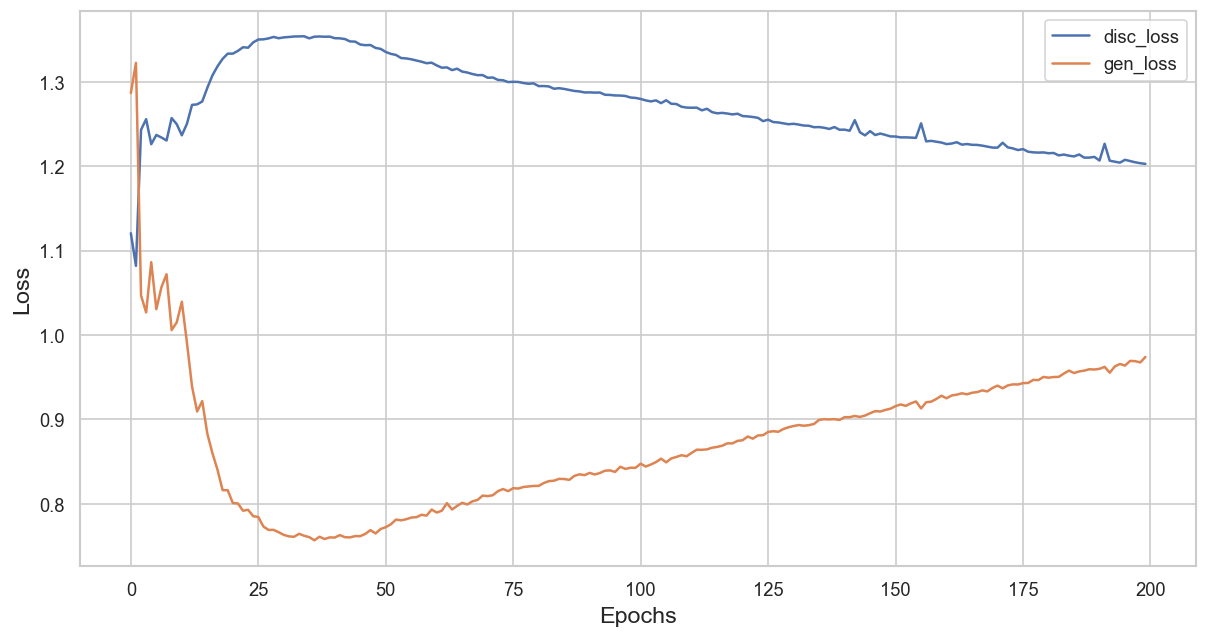

In [17]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_loss'], label='disc_loss')
plt.plot(history.history['g_loss'], label='gen_loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()
plt.show()

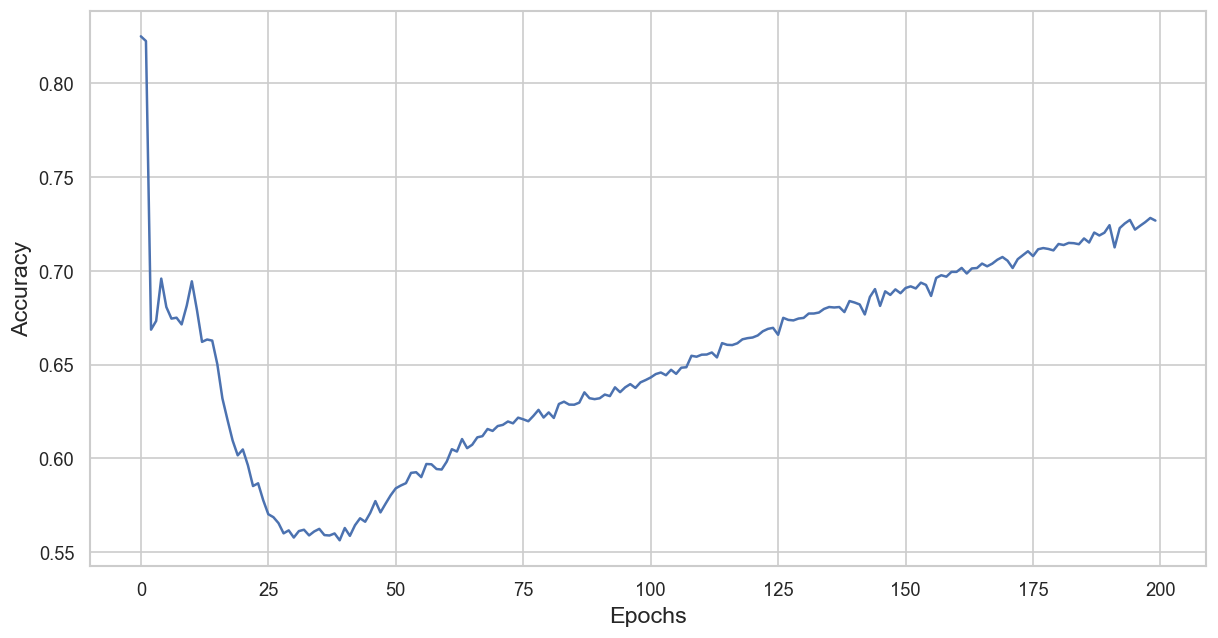

In [18]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_acc'], label='disc_acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.show()

In [19]:
latent_vectors = tf.random.normal(shape=(100, LATENT_DIM))
class_labels = tf.reshape(tf.range(10), shape=(10, 1))
class_labels = tf.tile(class_labels, multiples=(1, 10))
class_labels = tf.reshape(class_labels, shape=(100, 1))

generated_images = cdcgan.generator([latent_vectors, class_labels], training=False)
generated_images = (generated_images + 1) / 2

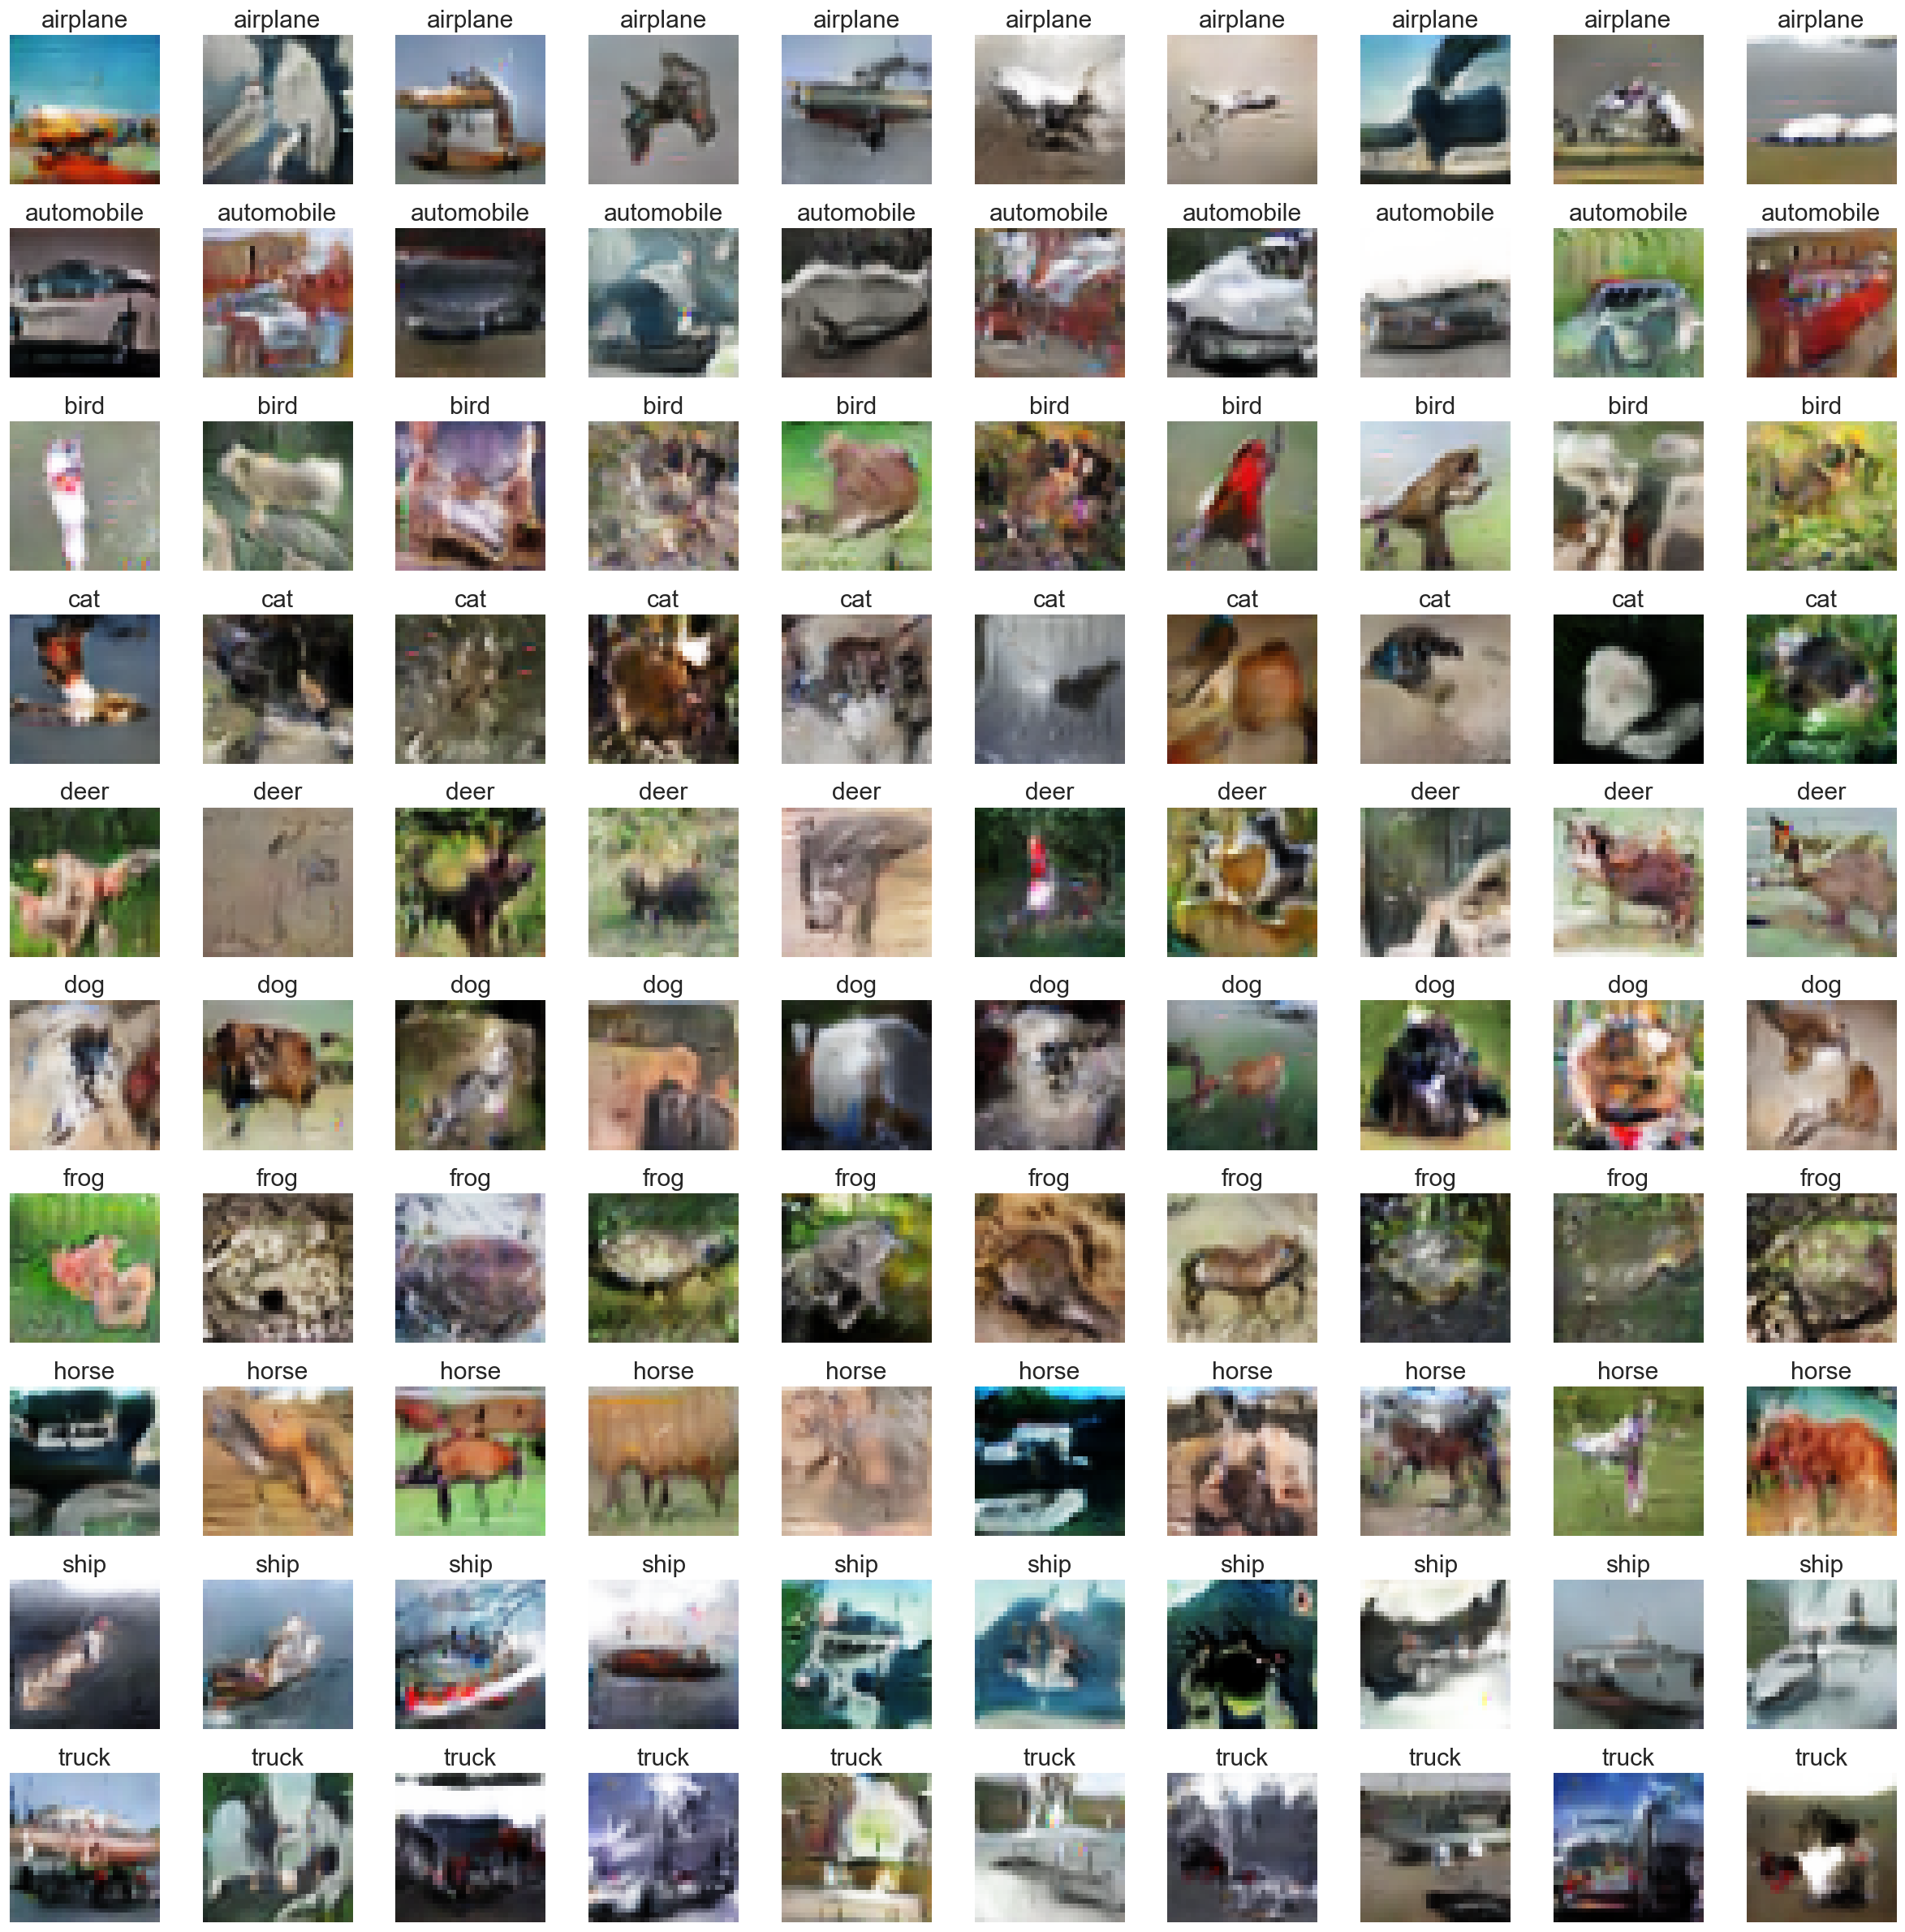

In [20]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.set_title(label_map[class_labels[i].numpy().item()], fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Visualizing Latent Space

## Export Model and Performance Metrics

In [21]:
# # export dcgan loss and acc results
# if not os.path.exists('performance'):
#     os.makedirs('performance')

# cdcgan_perf = dict(
#     g_loss=history.history['g_loss'],
#     d_loss=history.history['d_loss'],
#     d_acc=history.history['d_acc'],
# )

# with open('performance/cdcgan_perf.pickle', 'wb') as f:
#     pickle.dump(cdcgan_perf, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('performance/cdcgan_perf.pickle', 'rb') as f:
#     unserialized_data = pickle.load(f)

# assert cdcgan_perf == unserialized_data

## References

[1] Radford, A., Metz, L. and Chintala, S. (2016) Unsupervised representation learning with deep convolutional generative Adversarial Networks, arXiv.org. Available at: https://arxiv.org/abs/1511.06434 (Accessed: January 8, 2023). 

[2] Mirza, M. and Osindero, S. (2014) Conditional generative adversarial nets, arXiv.org. Available at: https://arxiv.org/abs/1411.1784 (Accessed: January 8, 2023). 